# Group 2: Neuromorphic Computing Project

## Project Description
Solving Classification Task using STDP-Embedded Spiking Neural Network.

**Original Paper**: Alexander Sboev, Danila Vlasov, Roman Rybka, and Alexey Serenko. Solv-ing a classification task by spiking neurons with stdp and temporal coding.Procedia computer science, 123:494–500, 2018.

### Contributors:
Chris Beem (s1044334)

Ajinkya Indulkar (s1034517)

Xiaoxuan Lei (s1025681)

Rodrigo Victoria Perez (s1034694)

In [1]:
# import libraries
import warnings
warnings.filterwarnings(action='ignore')

import random
import scipy.stats
import numpy as np
import pandas as pd
from brian2 import *
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import preprocessing

%matplotlib inline

## Temporal Encoding

### Description:
For temporal encoding of input data, we use the Gaussian Receptive Field (GRF) Technique \[1\].

### Reference Papers:
\[1\] Wang, J., Belatreche, A., Maguire, L., & Mcginnity, T. M. (2014). **An online supervised learning method for spiking neural networks with adaptive structure**. Neurocomputing, 144, 526-536.

\[2\] S.M. Bohte, H.L. Poutre , J.N. Kok, **Unsupervised clustering with spiking neurons by sparse temporal coding and multi-layer RBF networks**, in:Proceedings of the IEEE-INNS-ENNS International Joint Conference on Neural Networks, 2000, pp. 279–284.

In [2]:
# Load IRIS Dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

#### Generate Gaussian Receptive Fields

Create a vector (evenly spaced) for computing gaussian receptive fields. Increase granularity of this vector for smoother GRFs and spike time computation accuracy.

In [3]:
inp = np.around(np.arange(0, 10, 0.1), decimals=1) # input range for GRF encoding
inp_min = min(inp) # max value of input range
inp_max = max(inp) # min value of input range

Define number of neurons ($n$) required for the temporal encoding of input data. 

Compute sigma ($\sigma$) using the formula:

$\sigma = \frac{1}{\gamma}.\frac{\{I^i_{max} - I^i_{min}\}}{n - 2}$ ,where $i$ is input variable (sample), $\gamma$ works best with a value of **1.5** and $n > 0$

In [4]:
n = 20 # define number of neurons
sigma = (1/1.5) * (inp_max-inp_min)/(n-2) # compute standard deviation
sigma = round(sigma, 2) # round sigma to 2 decimal points

Compute Center of Gaussian ($\mu$) using the equation:

$\mu = I^n_{min} + \frac{2i - 3}{2}.\frac{\{I^i_{max} - I^i_{min}\}}{n - 2}$

In [5]:
# compute gaussian centers
mu = inp_min +  ((np.arange(0, n, 1) - 1.5) * (inp_max - inp_min) / (n-2))
mu

array([-0.825, -0.275,  0.275,  0.825,  1.375,  1.925,  2.475,  3.025,
        3.575,  4.125,  4.675,  5.225,  5.775,  6.325,  6.875,  7.425,
        7.975,  8.525,  9.075,  9.625])

Compute and Plot GRF for `inp` vector. 

Normalize it as the PDF returns a few values above 1. Refer to this [thread](https://stackoverflow.com/questions/32074115/can-normal-distribution-prob-density-be-greater-than-1-based-on-python-code) for more information.

In [6]:
# compute GRFs
grf = np.array([scipy.stats.norm(mu[i], sigma).pdf(inp) for i in range(n)])
grf = preprocessing.normalize(grf, axis=0)

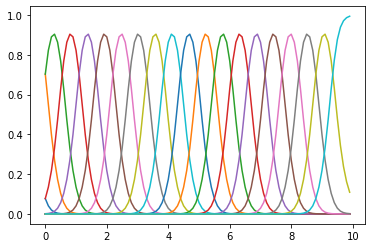

In [7]:
# visualization of GRFs
for i in range(n):
    plt.plot(inp, grf[i])

#### Compute Spike Timings

In [8]:
T_ref = 10 # Reference time for temporal encoding
spike_times = []
for i in range(len(X)):
    indices = np.where(np.in1d(inp, X[i]))[0] # extracts location of the elements of X[i] in inp array.
    spike_times_ps = [] # spike times per sample
    for idx in indices:
        grf_values = [-T_ref*g[idx]+T_ref for g in grf]
        spike_times_ps.append([-1 if g>=T_ref-1 else g for g in grf_values])
    spike_times_ps = np.around(np.array(spike_times_ps), decimals=2)
    spike_times.append(spike_times_ps)
    
spike_times = np.array(spike_times)

In [9]:
# check shape of array
spike_times.shape

(150, 4, 20)

#### Observe Spike Times of the first sample

In [10]:
# check encoding of first sample
spike_times[0]

array([[-1.  ,  6.01,  1.1 ,  7.82, -1.  , -1.  , -1.  , -1.  , -1.  ,
        -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
        -1.  , -1.  ],
       [-1.  , -1.  , -1.  ,  7.29,  0.96,  6.69, -1.  , -1.  , -1.  ,
        -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
        -1.  , -1.  ],
       [-1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,  6.01,  1.1 ,
         7.82, -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
        -1.  , -1.  ],
       [-1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
        -1.  ,  5.27,  1.36,  8.27, -1.  , -1.  , -1.  , -1.  , -1.  ,
        -1.  , -1.  ]])

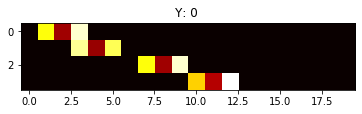

In [11]:
plt.imshow(spike_times[0], cmap='hot', interpolation='nearest')
plt.title("Y: {} ".format(y[0]))
plt.show()

### Create a Function for Temporal Encoding of Input Data

In [12]:
def gaussianRF(X, inp, n=20, T_ref=10):
    """
    @description:    
        Encoding input vector X via Gaussian Receptive Fields (GRFs)
    @arguments:
        X (array): dataset
        inp (array): input array for smooth GRFs
        n (int): number of neurons
        T_ref (int): Reference time for temporal encoding
    @returns:
        spike_times (array): array of spike times for all samples
    """
    # compute max and min of input
    inp_min = min(inp)
    inp_max = max(inp)
    # compute standard deviation
    sigma = (1/1.5) * (inp_max-inp_min)/(n-2)
    sigma = round(sigma, 2)
    # compute expectation
    mu = inp_min + ((np.arange(0, n, 1) - 1.5) * (inp_max - inp_min) / (n-2))
    # compute gaussian receptive fields
    grf = np.array([scipy.stats.norm(mu[i], sigma).pdf(inp) for i in range(n)])
    grf = preprocessing.normalize(grf, axis=0)
    # compute spike times for all instances of X
    spike_times = []
    for i in range(len(X)):
        # extract location of the elements of X[i] in inp array
        indices = np.where(np.in1d(inp, X[i]))[0]
        spike_times_ps = [] # spike times per sample
        for idx in indices:
            # compute spike times for all features (per sample)
            grf_values = [-T_ref*g[idx]+T_ref for g in grf]
            spike_times_ps.append([-1 if g>=T_ref-1 else g for g in grf_values])
        spike_times_ps = np.around(np.array(spike_times_ps), decimals=2)
        spike_times.append(spike_times_ps) # combine spike times of all samples
        
    spike_times = np.array(spike_times)
    return spike_times

In [13]:
def visualize_spikes(spike_times, label):
    plt.figure()
    plt.imshow(spike_times, cmap='hot', interpolation='nearest')
    plt.title("Label: {} ".format(label))
    plt.show()

## Spiking Neural Network Model Training

### Part 1: Data Pre-processing

Load Data and compute Spike Times for all samples

In [14]:
# load IRIS Dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# normalizing X
X_norm = np.around(preprocessing.normalize(X, axis=1), decimals=2)

Choose an input value range based on maximum and minimum values of iris dataset features.

In [15]:
# input vector
inp = np.around(np.arange(0, 1, 0.01), decimals=2)

Generate and Visualize Spike Times array using GRF Encoding (for $n$ = 20 and $T_{ref}$ = 10ms)

In [16]:
# compute spike times
spike_times = gaussianRF(X_norm, inp, n=20, T_ref=10)

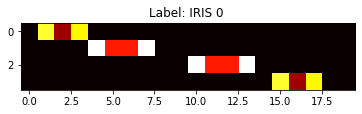

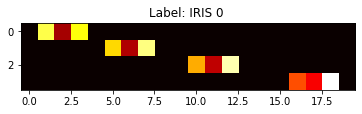

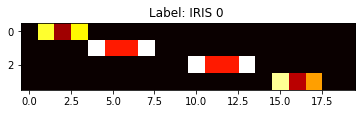

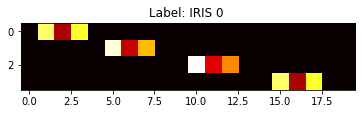

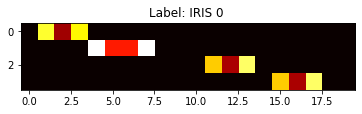

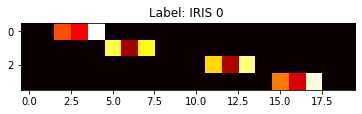

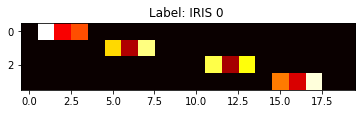

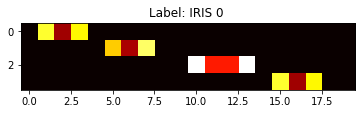

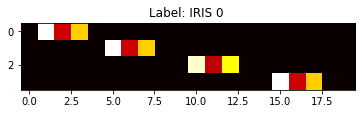

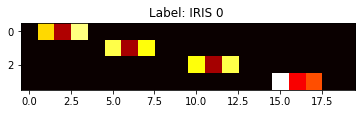

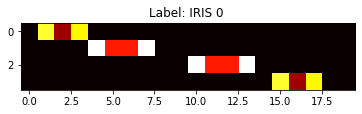

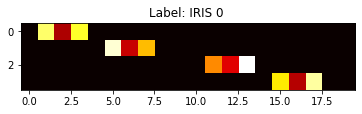

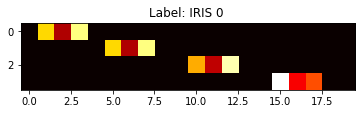

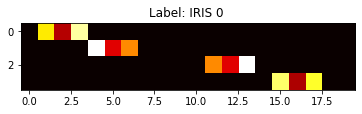

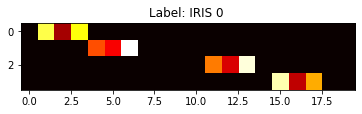

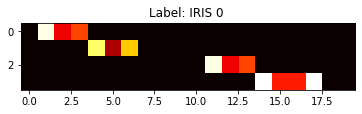

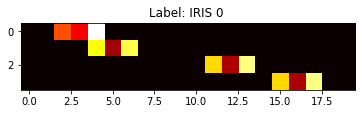

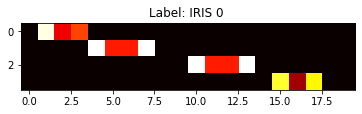

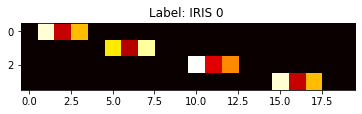

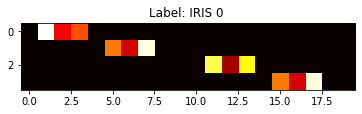

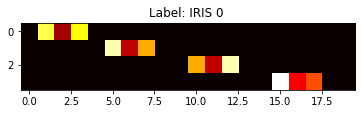

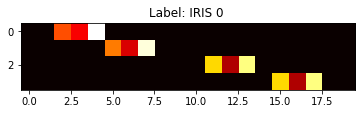

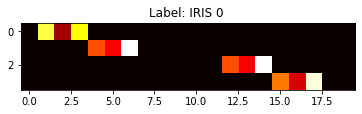

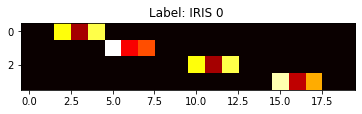

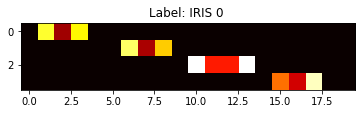

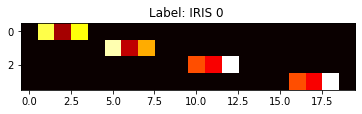

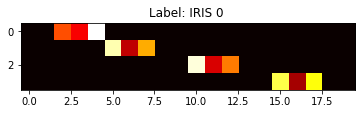

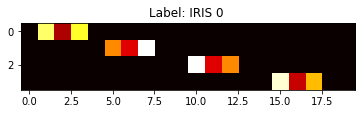

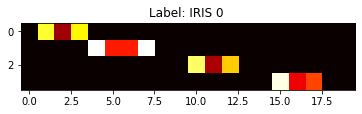

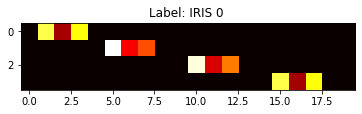

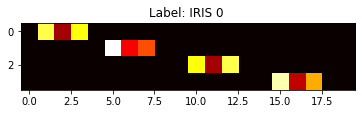

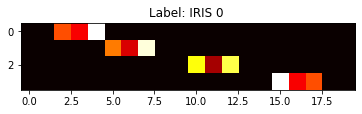

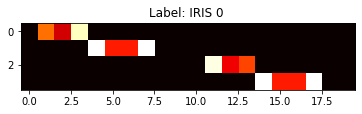

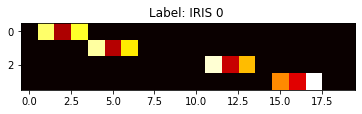

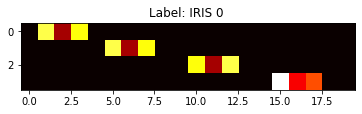

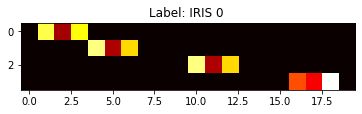

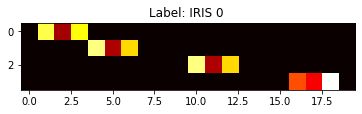

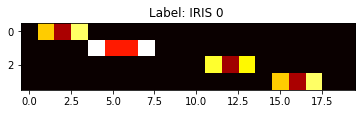

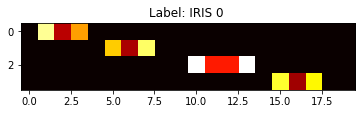

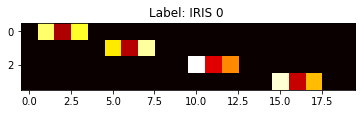

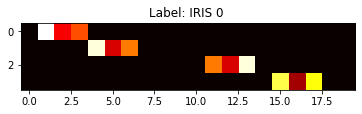

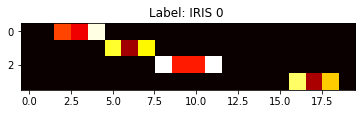

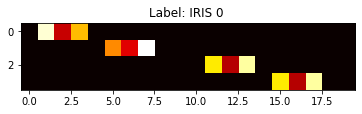

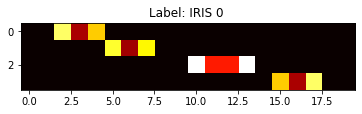

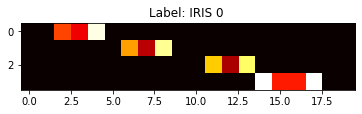

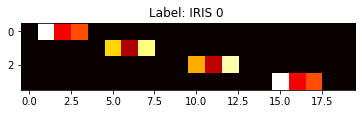

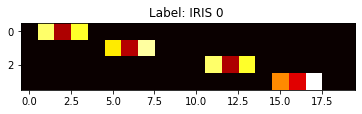

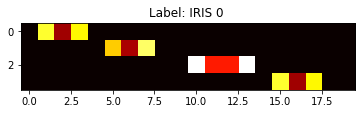

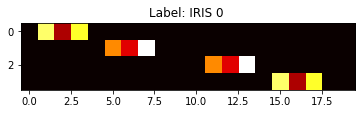

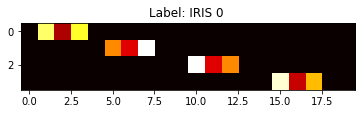

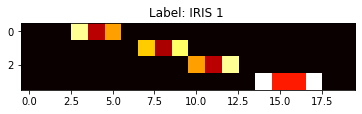

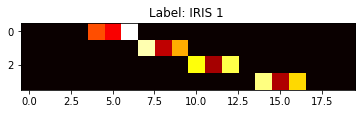

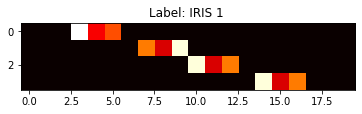

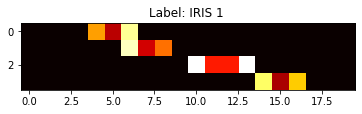

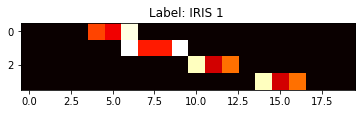

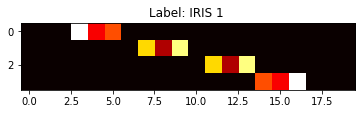

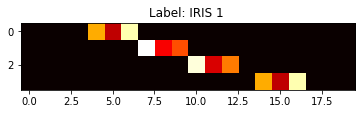

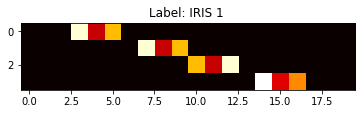

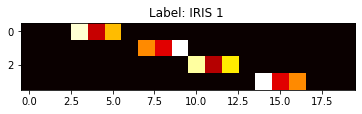

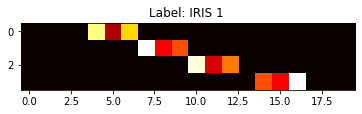

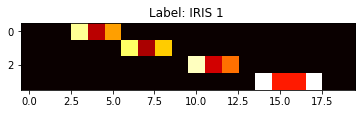

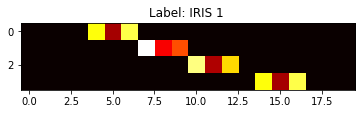

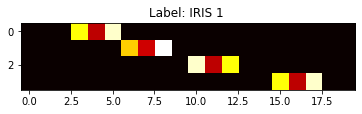

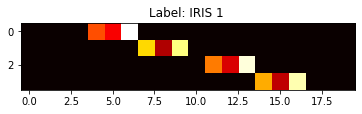

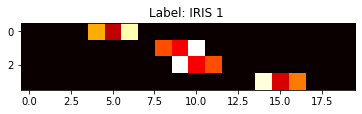

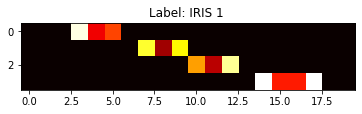

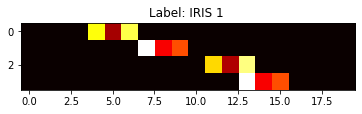

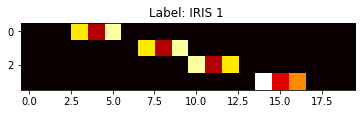

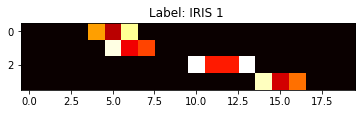

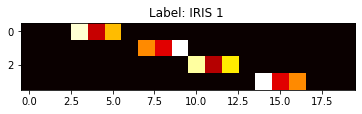

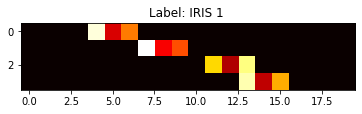

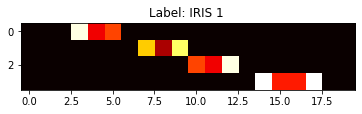

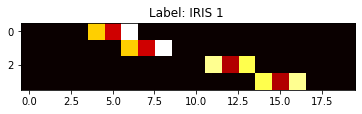

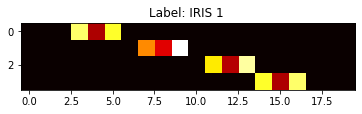

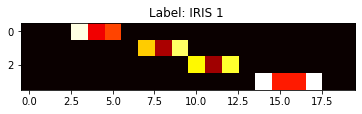

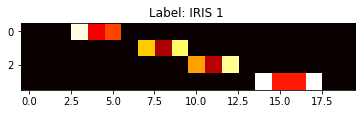

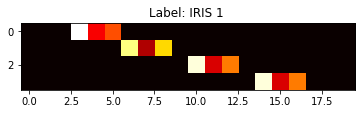

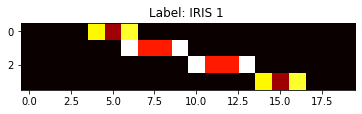

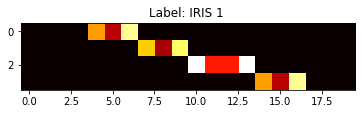

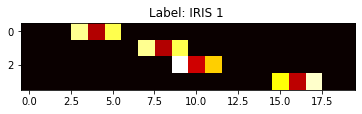

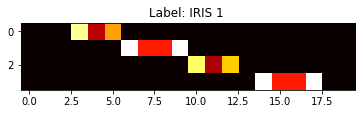

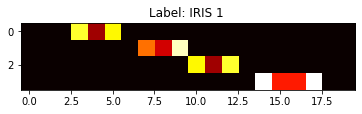

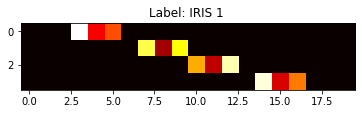

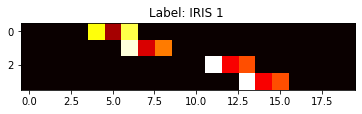

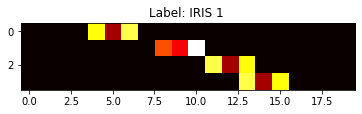

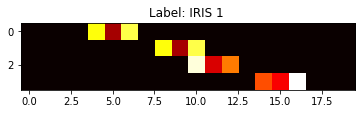

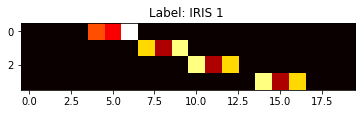

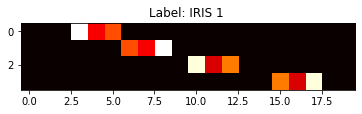

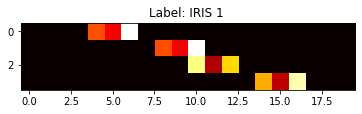

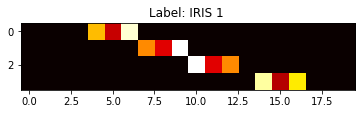

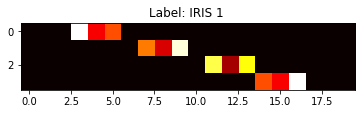

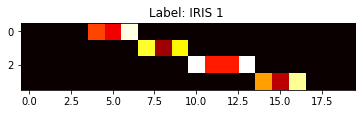

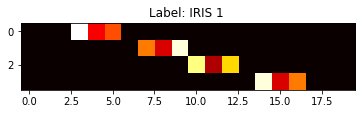

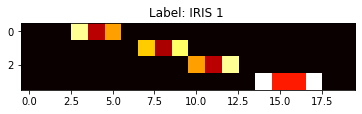

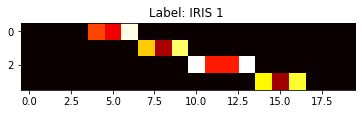

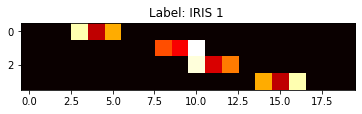

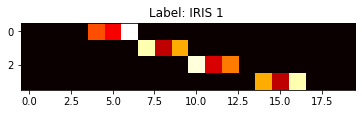

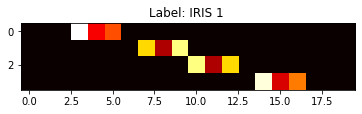

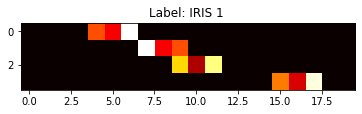

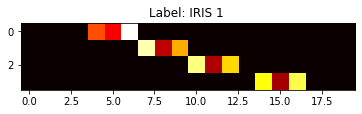

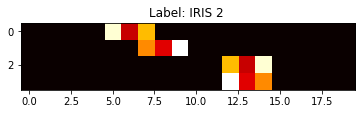

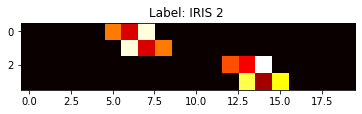

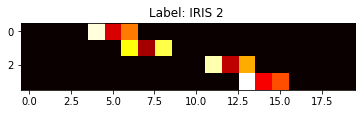

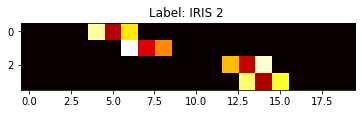

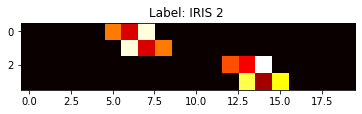

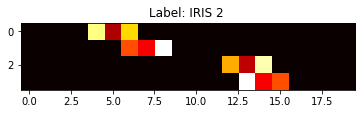

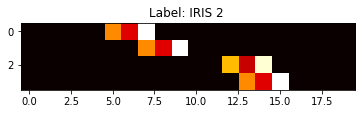

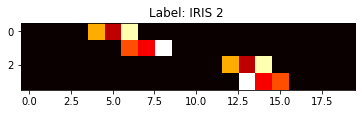

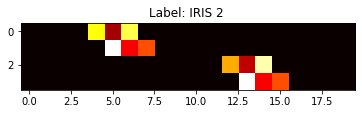

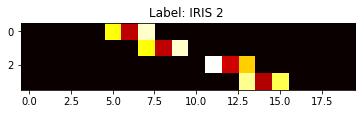

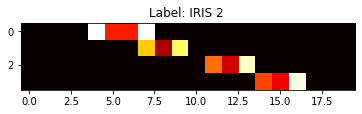

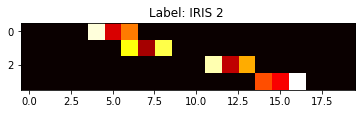

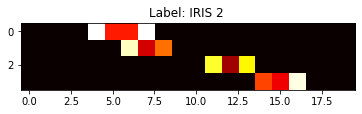

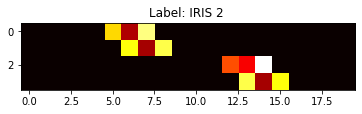

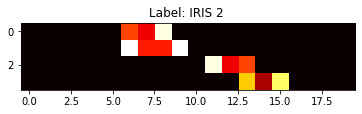

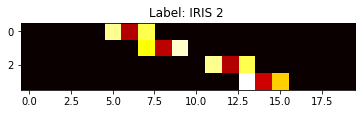

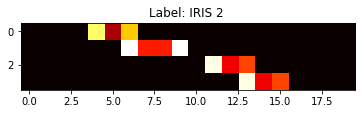

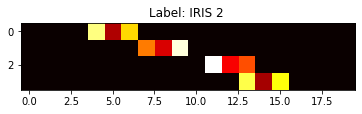

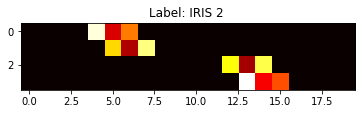

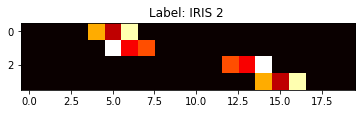

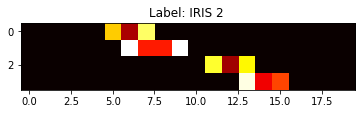

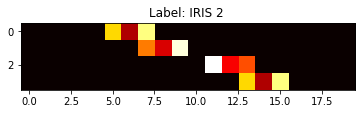

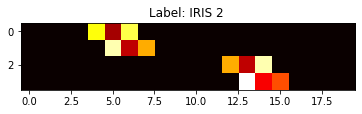

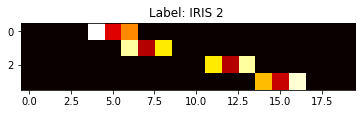

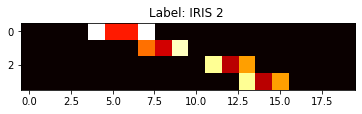

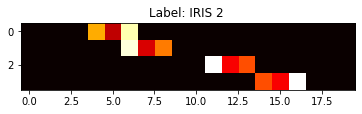

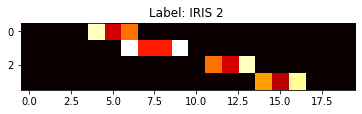

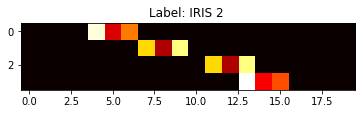

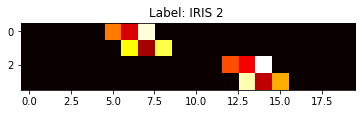

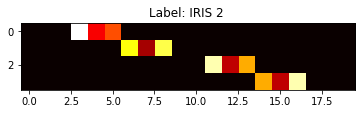

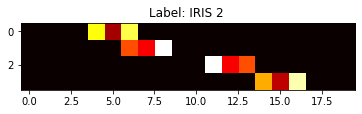

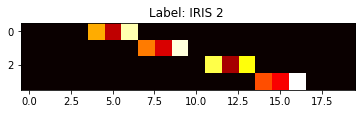

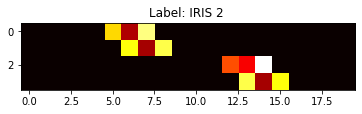

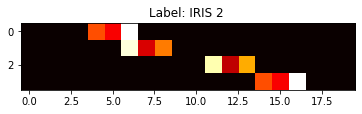

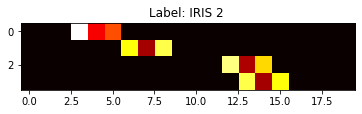

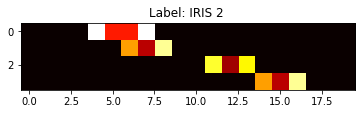

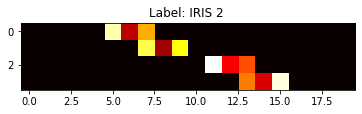

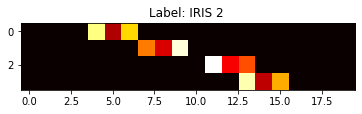

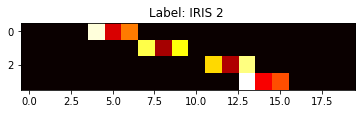

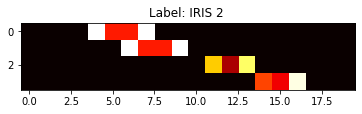

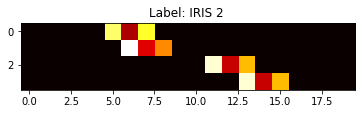

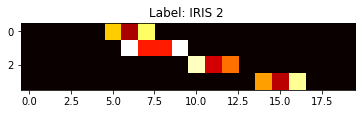

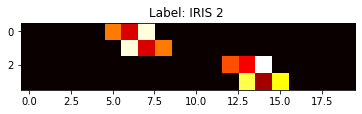

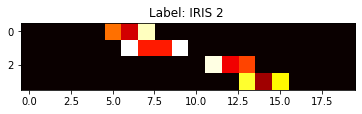

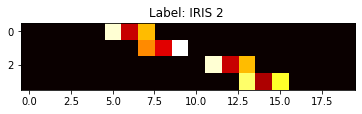

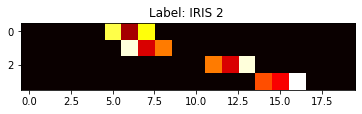

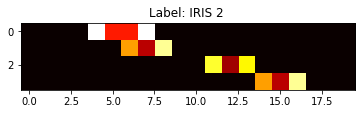

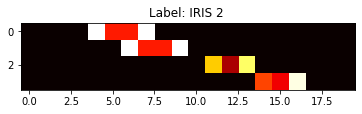

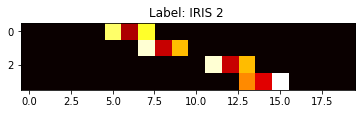

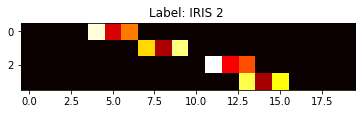

In [17]:
# visualize spike times
for t in range(spike_times.shape[0]):
    visualize_spikes(spike_times[t], 'IRIS {}'.format(y[t]))

#### Data Splitting
Here we create a train set of 34 unique samples and 50 with repetitions to get the same size as the original, and test set of 16 for each class.

In [18]:
# take validation examples from the dataset 
spike_times_test = np.copy(spike_times[0:16]),np.copy(spike_times[50:66]),np.copy(spike_times[100:116])
y_test = np.copy(y[0:16]),np.copy(y[50:66]),np.copy(y[100:116])

# repeat other values to keep the same size
spike_times[0:16] = spike_times[17:33]
spike_times[50:66] = spike_times[67:83]
spike_times[100:116] = spike_times[117:133]

### Part 2: Design SNN Model

In [20]:
# set the settings for how quickly the voltage in the neurons decay
import random
taupre = taupost = 1*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
n_neurons = 20 
random.seed(9) # set random seed

We take the `spike_times`, as they were defined before, and we concatenate them so that for each of the 3 flowers, we have a continuous sequence of neurons that fire.

We get both `the spike_feature_i` (the $n^{th}$ neuron to fire) and the `spike_feature_t` (the time $n^{th}$ neuron should fire).

In [21]:
spike_feature_i = [[],[],[]]
spike_feature_t = [[],[],[]]

n_instance = [0,0,0]
for i_instance,instance in enumerate(spike_times):
    flower = y[i_instance]
    for i_feature,feature in enumerate(instance):
        for i_val,val in enumerate(feature):
            if(val>0):
                spike_feature_i[flower].append(i_val+20*i_feature)
                spike_feature_t[flower].append(n_instance[flower]*20+i_val)
    n_instance[flower]+=1

# observe values for first 3 samples
print(spike_feature_i[0])
print(spike_feature_t[0])

print(spike_feature_i[1])
print(spike_feature_t[1])

print(spike_feature_i[2])
print(spike_feature_t[2])

[1, 2, 3, 24, 25, 26, 27, 50, 51, 52, 53, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 25, 26, 27, 51, 52, 53, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 75, 76, 77, 2, 3, 4, 25, 26, 27, 51, 52, 53, 75, 76, 77, 1, 2, 3, 24, 25, 26, 52, 53, 54, 75, 76, 77, 2, 3, 4, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 26, 27, 28, 50, 51, 52, 53, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 76, 77, 78, 2, 3, 4, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 24, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 75, 76, 77, 2, 3, 4, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 24, 25, 26, 27, 51, 52, 53, 74, 75, 76, 77, 2, 3, 4, 24, 25, 26, 51, 52, 53, 75, 76, 77, 1, 2, 3, 24, 25, 26, 27, 50, 51, 52, 53, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 75, 76, 77, 1, 2, 3, 25, 26, 27, 51, 52, 53, 75, 76, 77, 1, 2, 3, 25, 26, 27, 50, 51, 52, 75, 76, 77, 2, 3, 4, 25, 26, 27, 5

We create 3 spike generator groups. Each one responsible for one feature.

We also create 3 neuron groups. Each of them will be trained by one feature.

In [22]:
# create spiking generators per feature
Gf1 = SpikeGeneratorGroup(N=80,indices=spike_feature_i[0],times=spike_feature_t[0]*ms)
Gf2 = SpikeGeneratorGroup(N=80,indices=spike_feature_i[1],times=spike_feature_t[1]*ms)
Gf3 = SpikeGeneratorGroup(N=80,indices=spike_feature_i[2],times=spike_feature_t[2]*ms)

# create neuron groups per feature
Gpost_flower_1 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms)
Gpost_flower_2 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms)
Gpost_flower_3 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms)

We define the synapse between the pre-synaptic and post-synaptic neurons.

(The *3 x 20* feature neurons from the GRF encoding, and the 3 post-synaptic neurons that shall learn the features)

In [23]:
# define synapses
S_flower_1 = Synapses(Gf1, Gpost_flower_1,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre = Apre
             w = clip(w+apost, 1e-8, wmax)
             ''',
             on_post='''
             apost = Apost
             w = clip(w+apre, 1e-8, wmax)
             ''', method='linear')

S_flower_2 = Synapses(Gf2, Gpost_flower_2,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre = Apre
             w = clip(w+apost, 1e-8, wmax)
             ''',
             on_post='''
             apost = Apost
             w = clip(w+apre, 1e-8, wmax)
             ''', method='linear')

S_flower_3 = Synapses(Gf3, Gpost_flower_3,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre = Apre
             w = clip(w+apost, 1e-8, wmax)
             ''',
             on_post='''
             apost = Apost
             w = clip(w+apre, 1e-8, wmax)
             ''', method='linear')

# connect synapses between pre and post neurons
S_flower_1.connect()
S_flower_2.connect()
S_flower_3.connect()

#initialize synaptic weights
S_flower_1.w = np.add(S_flower_1.w,[wmax/20]*len(S_flower_1.w))
S_flower_2.w = np.add(S_flower_2.w,[wmax/20]*len(S_flower_2.w))
S_flower_3.w = np.add(S_flower_3.w,[wmax/20]*len(S_flower_3.w))

Create monitors to observe model training

In [24]:
# create monitors per post neurons
Monitor_1 = StateMonitor(S_flower_1, ['v','w', 'apre', 'apost'], record=True)
Monitor_2 = StateMonitor(S_flower_2, ['v','w', 'apre', 'apost'], record=True)
Monitor_3 = StateMonitor(S_flower_3, ['v','w', 'apre', 'apost'], record=True)

### Part 3: Run Model

Run for 1 second. This will run all instances as we have concatenated all the spike times.

In [25]:
run(1000*ms)

### Part 4: Model Training Visualization

We plot everything that we have monitored.

We have 3 plots per each flower. 
* the pre and post trail voltages (by how much the weights should be changed)
* synaptic weights
* the voltage inside the post neuron

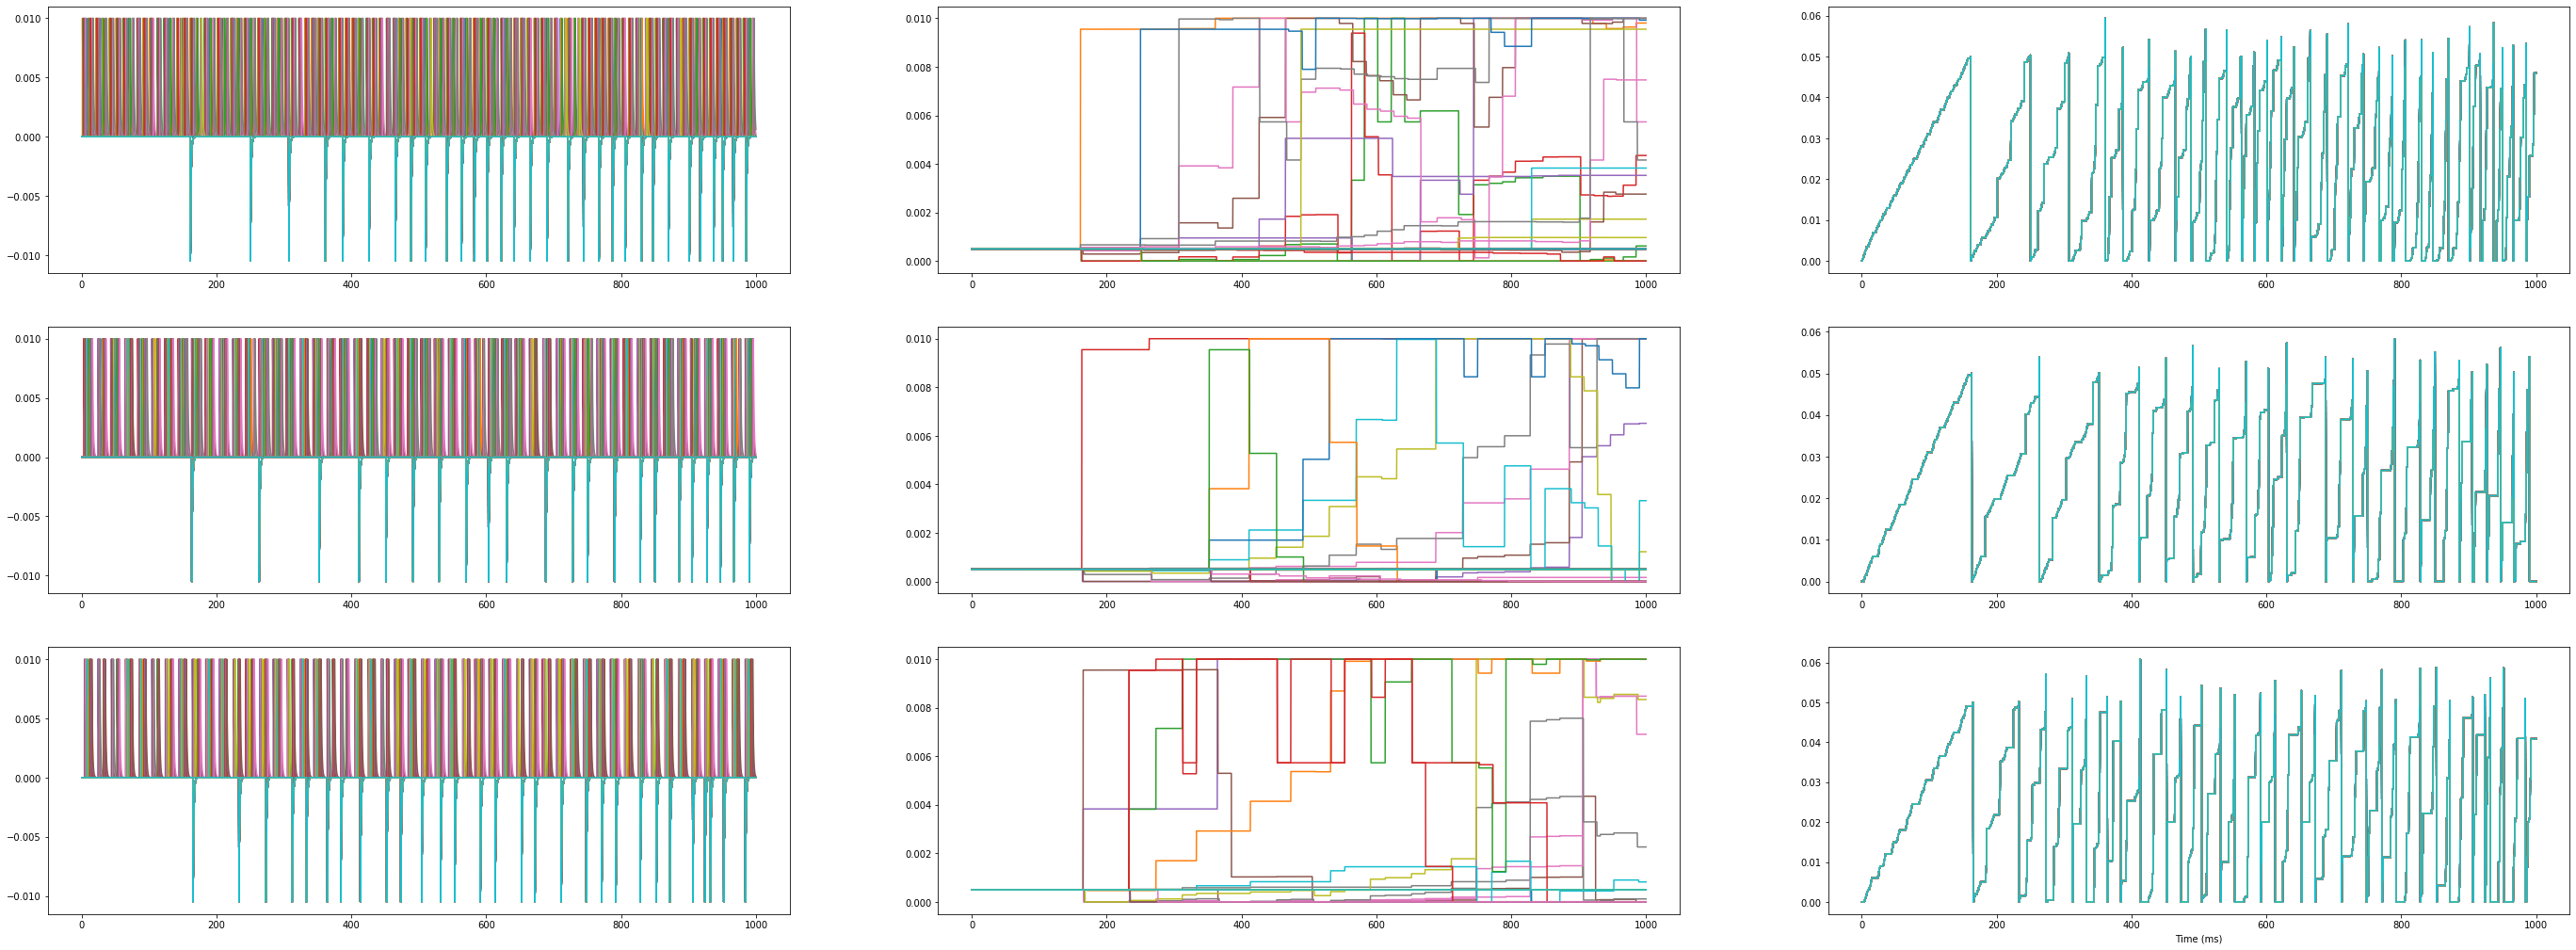

In [26]:
figure(figsize=(48, 24))
subplot(431)
for i,data in enumerate(Monitor_1.apre):
    plot(Monitor_1.t/ms, data, label='apre {}'.format(i))
for i, data in enumerate(Monitor_1.apost):
    plot(Monitor_1.t/ms, data, label='apost {}'.format(i))

subplot(434)
for i,data in enumerate(Monitor_2.apre):
    plot(Monitor_2.t/ms, data, label='apre {}'.format(i))
for i, data in enumerate(Monitor_2.apost):
    plot(Monitor_2.t/ms, data, label='apost {}'.format(i))

subplot(437)
for i,data in enumerate(Monitor_3.apre):
    plot(Monitor_3.t/ms, data, label='apre {}'.format(i))
for i, data in enumerate(Monitor_3.apost):
    plot(Monitor_3.t/ms, data, label='apost {}'.format(i))


subplot(432)
for i,data in enumerate(Monitor_1.w):
    plot(Monitor_1.t/ms, data, label='w1 {}'.format(i))


subplot(435)
for i,data in enumerate(Monitor_2.w):
    plot(Monitor_2.t/ms, data, label='w2 {}'.format(i))


subplot(438)
for i,data in enumerate(Monitor_3.w):
    plot(Monitor_3.t/ms, data, label='w3 {}'.format(i))



subplot(433)
for i,data in enumerate(Monitor_1.v):
    plot(Monitor_1.t/ms, data, label='v1 {}'.format(i))


subplot(436)
for i,data in enumerate(Monitor_2.v):
    plot(Monitor_2.t/ms, data, label='v2 {}'.format(i))


subplot(439)
for i,data in enumerate(Monitor_3.v):
    plot(Monitor_1.t/ms, data, label='v3 {}'.format(i))


xlabel('Time (ms)');

show()

### Part 5: Build Test Network

With a restart scope, we throw away all the elements from the previous network, and start creating a new network.

In [27]:
start_scope()

For our test , we will create 9 networks.

We have 3 different input spiketrains (from the 3 flowers) and we have 3 different weight matrices (that we trained before)

* We will create a network where we connect the flower 1 input spiketrain via the weight matrix 1 to an output neuron.
* We will create a network where we connect the flower 1 input spiketrain via the weight matrix 2 to an output neuron. 
* We will create a network where we connect the flower 1 input spiketrain via the weight matrix 3 to an output neuron. 
* We will create a network where we connect the flower 2 input spiketrain via the weight matrix 1 to an output neuron. 

and so on, till we have 9 networks

As BRIAN2 really does not like **networks to be placed in arrays**, we have to declare many networks by hand in this codeblock.

In [28]:
# create spike generators 
tpre_1 = SpikeGeneratorGroup(N=80,indices=spike_feature_i[0],times=spike_feature_t[0]*ms)
tpre_2 = SpikeGeneratorGroup(N=80,indices=spike_feature_i[1],times=spike_feature_t[1]*ms)
tpre_3 = SpikeGeneratorGroup(N=80,indices=spike_feature_i[2],times=spike_feature_t[2]*ms)

tpost1 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost2 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost3 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost4 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost5 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost6 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost7 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost8 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 
tpost9 = NeuronGroup(1, 'v:1', threshold='v>0.05',reset = 'v=0', refractory=1*ms) 

Synapse_test_flower_11  = Synapses(tpre_1, tpost1,''' w : 1 \n n_f1 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f1+=1 \n disable_fire=1 ''', method='linear')
Synapse_test_flower_12  = Synapses(tpre_2, tpost2,''' w : 1 \n n_f2 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f2+=1 \n disable_fire=1 ''', method='linear')
Synapse_test_flower_13  = Synapses(tpre_3, tpost3,''' w : 1 \n n_f3 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f3+=1 \n disable_fire=1 ''', method='linear')

Synapse_test_flower_21  = Synapses(tpre_1, tpost4,''' w : 1 \n n_f1 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f1+=1 \n disable_fire=1 ''', method='linear')
Synapse_test_flower_22  = Synapses(tpre_2, tpost5,''' w : 1 \n n_f2 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f2+=1 \n disable_fire=1 ''', method='linear')
Synapse_test_flower_23  = Synapses(tpre_3, tpost6,''' w : 1 \n n_f3 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f3+=1 \n disable_fire=1 ''', method='linear')

Synapse_test_flower_31  = Synapses(tpre_1, tpost7,''' w : 1 \n n_f1 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f1+=1 \n disable_fire=1 ''', method='linear')
Synapse_test_flower_32  = Synapses(tpre_2, tpost8,''' w : 1 \n n_f2 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f2+=1 \n disable_fire=1 ''', method='linear')
Synapse_test_flower_33  = Synapses(tpre_3, tpost9,''' w : 1 \n n_f3 : 1 \n disable_fire : 1 ''', on_pre=''' v_post += (w*disable_fire) ''',on_post=''' n_f3+=1 \n disable_fire=1 ''', method='linear')

Synapse_test_flower_11.connect()
Synapse_test_flower_12.connect()
Synapse_test_flower_13.connect()

Synapse_test_flower_21.connect()
Synapse_test_flower_22.connect()
Synapse_test_flower_23.connect()

Synapse_test_flower_31.connect()
Synapse_test_flower_32.connect()
Synapse_test_flower_33.connect()

We set the weights of all the networks to the weights that we trained earlier.

In [29]:
Synapse_test_flower_11.w = S_flower_1.w
Synapse_test_flower_12.w = S_flower_1.w
Synapse_test_flower_13.w = S_flower_1.w

Synapse_test_flower_21.w = S_flower_2.w
Synapse_test_flower_22.w = S_flower_2.w
Synapse_test_flower_23.w = S_flower_2.w

Synapse_test_flower_31.w = S_flower_3.w
Synapse_test_flower_32.w = S_flower_3.w
Synapse_test_flower_33.w = S_flower_3.w

We create some spike monitors to keep track of what neuron spiked, and some variable monitors to keep track of the output neuron voltage.

In [30]:
spikemon_11 = SpikeMonitor(tpost1)
spikemon_12 = SpikeMonitor(tpost2)
spikemon_13 = SpikeMonitor(tpost3)

spikemon_21 = SpikeMonitor(tpost4)
spikemon_22 = SpikeMonitor(tpost5)
spikemon_23 = SpikeMonitor(tpost6)

spikemon_31 = SpikeMonitor(tpost7)
spikemon_32 = SpikeMonitor(tpost8)
spikemon_33 = SpikeMonitor(tpost9)

Test_Monitor_11 = StateMonitor(Synapse_test_flower_11, ['v'], record=True)
Test_Monitor_12 = StateMonitor(Synapse_test_flower_12, ['v'], record=True)
Test_Monitor_13 = StateMonitor(Synapse_test_flower_13, ['v'], record=True)

Test_Monitor_21 = StateMonitor(Synapse_test_flower_21, ['v'], record=True)
Test_Monitor_22 = StateMonitor(Synapse_test_flower_22, ['v'], record=True)
Test_Monitor_23 = StateMonitor(Synapse_test_flower_23, ['v'], record=True)

Test_Monitor_31 = StateMonitor(Synapse_test_flower_31, ['v'], record=True)
Test_Monitor_32 = StateMonitor(Synapse_test_flower_32, ['v'], record=True)
Test_Monitor_33 = StateMonitor(Synapse_test_flower_33, ['v'], record=True)

We run the whole spiketrain, Every 20ms is one instance.

There are 50 instances. We reset the post neuron voltage after each 20 ms.

Thus, during each period of 20 ms , one instance is shown to the network.

In [31]:
for i_run in range(50):
  print("[{} of 50".format(i_run),end = '') 
  run(20*ms)
  tpost1.v=0
  tpost2.v=0
  tpost3.v=0
  tpost4.v=0
  tpost5.v=0
  tpost6.v=0
  tpost7.v=0
  tpost8.v=0
  tpost9.v=0

  Synapse_test_flower_11.disable_fire=1
  Synapse_test_flower_12.disable_fire=1
  Synapse_test_flower_13.disable_fire=1
  Synapse_test_flower_21.disable_fire=1
  Synapse_test_flower_22.disable_fire=1
  Synapse_test_flower_23.disable_fire=1
  Synapse_test_flower_31.disable_fire=1
  Synapse_test_flower_32.disable_fire=1
  Synapse_test_flower_33.disable_fire=1

[0 of 50[1 of 50[2 of 50[3 of 50[4 of 50[5 of 50[6 of 50[7 of 50[8 of 50[9 of 50[10 of 50[11 of 50[12 of 50[13 of 50[14 of 50[15 of 50[16 of 50[17 of 50[18 of 50[19 of 50[20 of 50[21 of 50[22 of 50[23 of 50[24 of 50[25 of 50[26 of 50[27 of 50[28 of 50[29 of 50[30 of 50[31 of 50[32 of 50[33 of 50[34 of 50[35 of 50[36 of 50[37 of 50[38 of 50[39 of 50[40 of 50[41 of 50[42 of 50[43 of 50[44 of 50[45 of 50[46 of 50[47 of 50[48 of 50[49 of 50

We display how many we have correct and we plot the spikes and the voltages of the output neurons.

Testset 1 on feature extractor 1 yields 46.0/50 classifications of flower 1
Testset 1 on feature extractor 2 yields 15.0/50 classifications of flower 2
Testset 1 on feature extractor 3 yields 0.0/50 classifications of flower 3
Testset 2 on feature extractor 1 yields 0.0/50 classifications of flower 1
Testset 2 on feature extractor 2 yields 31.0/50 classifications of flower 2
Testset 2 on feature extractor 3 yields 0.0/50 classifications of flower 3
Testset 3 on feature extractor 1 yields 1.0/50 classifications of flower 1
Testset 3 on feature extractor 2 yields 8.0/50 classifications of flower 2
Testset 3 on feature extractor 3 yields 14.0/50 classifications of flower 3


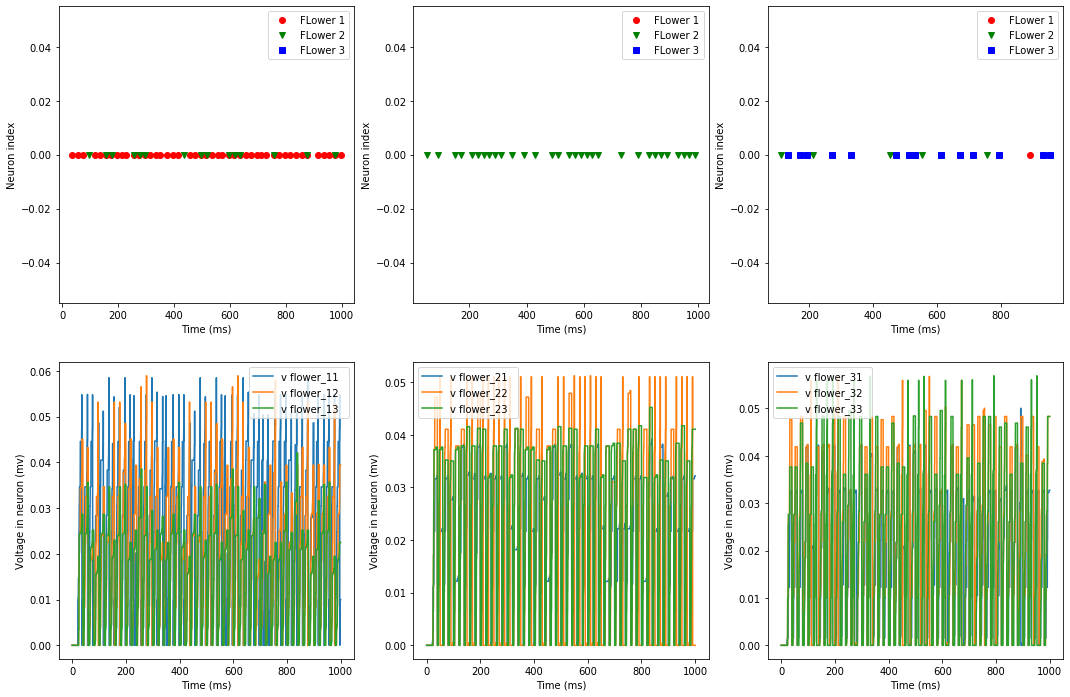

In [32]:
print("Testset 1 on feature extractor 1 yields {}/50 classifications of flower 1".format(Synapse_test_flower_11.n_f1[0]))
print("Testset 1 on feature extractor 2 yields {}/50 classifications of flower 2".format(Synapse_test_flower_12.n_f2[0]))
print("Testset 1 on feature extractor 3 yields {}/50 classifications of flower 3".format(Synapse_test_flower_13.n_f3[0]))

print("Testset 2 on feature extractor 1 yields {}/50 classifications of flower 1".format(Synapse_test_flower_21.n_f1[0]))
print("Testset 2 on feature extractor 2 yields {}/50 classifications of flower 2".format(Synapse_test_flower_22.n_f2[0]))
print("Testset 2 on feature extractor 3 yields {}/50 classifications of flower 3".format(Synapse_test_flower_23.n_f3[0]))

print("Testset 3 on feature extractor 1 yields {}/50 classifications of flower 1".format(Synapse_test_flower_31.n_f1[0]))
print("Testset 3 on feature extractor 2 yields {}/50 classifications of flower 2".format(Synapse_test_flower_32.n_f2[0]))
print("Testset 3 on feature extractor 3 yields {}/50 classifications of flower 3".format(Synapse_test_flower_33.n_f3[0]))

figure(figsize=(18, 12))
subplot(231)
plot(spikemon_11.t/ms, spikemon_11.i, 'or',label='FLower 1')
plot(spikemon_12.t/ms, spikemon_12.i, 'vg',label='FLower 2')
plot(spikemon_13.t/ms, spikemon_13.i, 'sb',label='FLower 3')
legend(loc = 'best')
xlabel('Time (ms)')
ylabel('Neuron index');

subplot(232)
plot(spikemon_21.t/ms, spikemon_21.i, 'or',label='FLower 1')
plot(spikemon_22.t/ms, spikemon_22.i, 'vg',label='FLower 2')
plot(spikemon_23.t/ms, spikemon_23.i, 'sb',label='FLower 3')
legend(loc = 'best')
xlabel('Time (ms)')
ylabel('Neuron index');

subplot(233)
plot(spikemon_31.t/ms, spikemon_31.i, 'or',label='FLower 1')
plot(spikemon_32.t/ms, spikemon_32.i, 'vg',label='FLower 2')
plot(spikemon_33.t/ms, spikemon_33.i, 'sb',label='FLower 3')
legend(loc = 'best')
xlabel('Time (ms)')
ylabel('Neuron index');

subplot(234)
plot(Test_Monitor_11.t/ms, Test_Monitor_11.v[0], label='v flower_11 {}'.format(' '))
plot(Test_Monitor_12.t/ms, Test_Monitor_12.v[0], label='v flower_12 {}'.format(' '))
plot(Test_Monitor_13.t/ms, Test_Monitor_13.v[0], label='v flower_13 {}'.format(' '))

legend(loc = 'best')
xlabel('Time (ms)');
ylabel('Voltage in neuron (mv)');

subplot(235)
plot(Test_Monitor_21.t/ms, Test_Monitor_21.v[0], label='v flower_21 {}'.format(' '))
plot(Test_Monitor_22.t/ms, Test_Monitor_22.v[0], label='v flower_22 {}'.format(' '))
plot(Test_Monitor_23.t/ms, Test_Monitor_23.v[0], label='v flower_23 {}'.format(' '))

legend(loc = 'best')
xlabel('Time (ms)');
ylabel('Voltage in neuron (mv)');

subplot(236)
plot(Test_Monitor_31.t/ms, Test_Monitor_31.v[0], label='v flower_31 {}'.format(' '))
plot(Test_Monitor_32.t/ms, Test_Monitor_32.v[0], label='v flower_32 {}'.format(' '))
plot(Test_Monitor_33.t/ms, Test_Monitor_33.v[0], label='v flower_33 {}'.format(' '))
 
legend(loc = 'best')
xlabel('Time (ms)');
ylabel('Voltage in neuron (mv)');

show()

# We create a classifier to test on unseen data 

# How much accuracy can we get from this data encoding?
To see that the encoding works and that the validation set is defined correctly we can measure the accuracy of other model on this same data.

In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Test data 
test_spikes = np.concatenate((spike_times_test[0],spike_times_test[1],spike_times_test[2]))
# Test label
test_y = np.concatenate((y_test[0],y_test[1],y_test[2]))

c = list(zip(test_spikes, test_y))
 
random.shuffle(c)  # Shuffle the data to get a random order of test samples 

test_X, test_Y= zip(*c)    # This is the test set   <---------------------------------------- 

flat_test_X=[np.concatenate((test_X[i][0],test_X[i][1],test_X[i][2],test_X[i][3])) for i in range(len(test_X))]
# To compare we try with an MLP classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
# Get the spikes in to a flat vector f_spike
f_spike=[np.concatenate((spike_times[i][0],spike_times[i][1],spike_times[i][2],spike_times[i][3])) for i in range(150)]
# Train it 
clf.fit(f_spike,y)        # This is the train set   <----------------------------------------

# And with this encoding and partition of the data we get 93% accuracy 
print(accuracy_score(test_Y, clf.predict(flat_test_X)),'% percentage of accuracy')

0.9375 % percentage of accuracy


# Now we write a function to call on the trained model

In [72]:

def classifier2(spike_feature_t, image=False):
    start_scope() # Each example is taken with time starting at zero
    spike_feature_i = [i for i in range(80)] 
    spike_feature_t = np.where(spike_feature_t==-1,100, spike_feature_t)
    
    tpre_1 = SpikeGeneratorGroup(N=80,indices=spike_feature_i,times=spike_feature_t*ms) # Every input is the same 
    tpre_2 = SpikeGeneratorGroup(N=80,indices=spike_feature_i,times=spike_feature_t*ms)
    tpre_3 = SpikeGeneratorGroup(N=80,indices=spike_feature_i,times=spike_feature_t*ms)
    
    tpost1 = NeuronGroup(1, 'v:1', threshold='v>0.045',reset = 'v=0', refractory=1*ms)  # Recreate the network
    tpost2 = NeuronGroup(1, 'v:1', threshold='v>0.04',reset = 'v=0', refractory=1*ms) 
    tpost3 = NeuronGroup(1, 'v:1', threshold='v>0.045',reset = 'v=0', refractory=1*ms)
    
    Synapse_test_flower_11  = Synapses(tpre_1, tpost1,''' w : 1 \n n_f1 : 1 ''',
                                       on_pre=''' v_post += (w) ''',on_post=''' n_f1+=1 \n ''', method='linear')
    Synapse_test_flower_12  = Synapses(tpre_2, tpost2,''' w : 1 \n n_f2 : 1 ''',
                                       on_pre=''' v_post += (w) ''',on_post=''' n_f2+=1 \n ''', method='linear')
    Synapse_test_flower_13  = Synapses(tpre_3, tpost3,''' w : 1 \n n_f3 : 1 ''',
                                       on_pre=''' v_post += (w) ''',on_post=''' n_f3+=1 \n ''', method='linear')

    Synapse_test_flower_11.connect()
    Synapse_test_flower_12.connect()
    Synapse_test_flower_13.connect()
    
    Synapse_test_flower_11.w = S_flower_1.w # Load each weight
    Synapse_test_flower_12.w = S_flower_2.w
    Synapse_test_flower_13.w = S_flower_3.w
    
    spikemon_11 = SpikeMonitor(tpost1)
    spikemon_12 = SpikeMonitor(tpost2)
    spikemon_13 = SpikeMonitor(tpost3)
    
    Test_Monitor_11 = StateMonitor(Synapse_test_flower_11, ['v'], record=True)
    Test_Monitor_12 = StateMonitor(Synapse_test_flower_12, ['v'], record=True)
    Test_Monitor_13 = StateMonitor(Synapse_test_flower_13, ['v'], record=True)
    run(40*ms)
    tpost1.v=0
    tpost2.v=0
    tpost3.v=0
    
    if image: # Show the graphs 
        figure(figsize=(15, 10))
        subplot(231)
        plot(Test_Monitor_11.t/ms, Test_Monitor_11.v[0], label='v flower_11 {}'.format(' '))
        subplot(232)
        plot(Test_Monitor_12.t/ms, Test_Monitor_12.v[0], label='v flower_12 {}'.format(' '))
        subplot(233)
        plot(Test_Monitor_13.t/ms, Test_Monitor_13.v[0], label='v flower_13 {}'.format(' '))
        subplot(234)
        plot(spikemon_11.t/ms, spikemon_11.i, 'or',label='FLower 1')
        subplot(235)
        plot(spikemon_12.t/ms, spikemon_12.i, 'vg',label='FLower 2')
        subplot(236)
        plot(spikemon_13.t/ms, spikemon_13.i, 'sb',label='FLower 3')

    r=[spikemon_11.t/ms,spikemon_12.t/ms,spikemon_13.t/ms]
    fx=[] # We avoid the empty list by transforming it into a list of numbers with set to 100 if the element in the list is empty
    for x in r:
        if len(x)>0:
            fx.append(x[0])
        else:
            fx.append(100)
    r=np.argmin(fx) # Now we can take the firs spike 
    return r

# We run the function for each example in the training set.

In [73]:
results=[]
for i in range(len(flat_test_X)):
    results.append(classifier2(flat_test_X[i])==test_Y[i])

We calculate the percentage of correct predictions 

In [74]:
print(100*sum(results)/len(results),'% percentage of accuracy')

68.75 % percentage of accuracy


For any value from the test set, we can see the response in ms of each post population.

real class 1
Response class 1


(None, None)

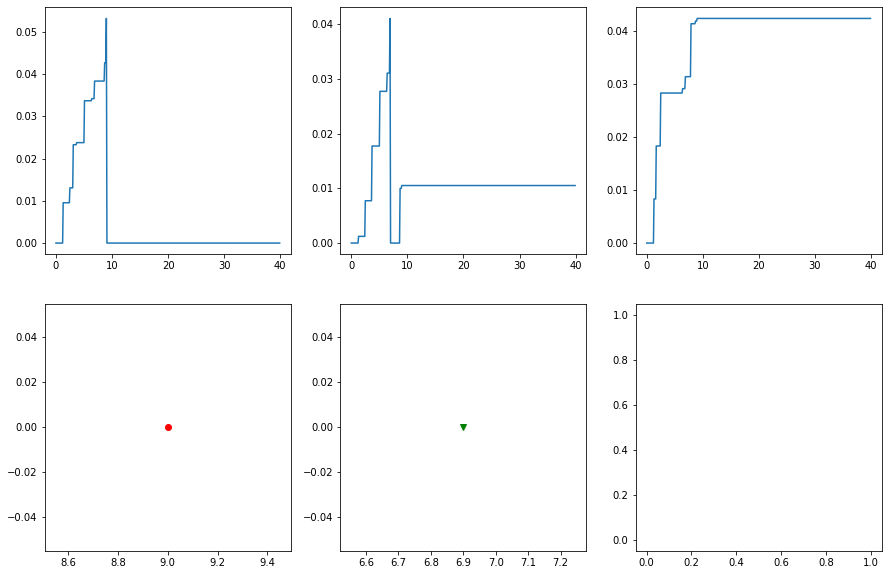

In [75]:
# For example k in the test set we show the graphs of response
ExampleNumber=2
r=classifier2(flat_test_X[ExampleNumber],image=True)
print('real class',test_Y[ExampleNumber]), print('Response class',r)